## 1.Setup

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import skimage
import os
from skimage.color import rgb2hsv
from skimage.color import rgb2gray
import scipy.misc
import imageio
import pandas as pd
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage import img_as_ubyte
import cv2
from scipy import ndimage

In [4]:
#data path
DISNEY_DIR = "images_disney"
HAYAO_DIR = "images_hayao"

## 2.Feature extraction

In [5]:
def calc_stats(fname):
    img =  io.imread(fname)
    denoi_img= cv2.fastNlMeansDenoisingColored(img) # get the denoised image
    hsv_img = rgb2hsv(denoi_img) # get the hsv image
    hue_img = hsv_img[:, :, 0] #get the hues
    saturation_img = hsv_img[:,:, 1] #get the saturations
    value_img = hsv_img[:, :, 2] #get the values
    ent_img = entropy(rgb2gray(denoi_img), disk(5)) #get the entropy
    sobel_x = ndimage.sobel(value_img, axis=0, mode='constant')
    sobel_y = ndimage.sobel(value_img, axis=1, mode='constant')
    edge_image = np.hypot(sobel_x, sobel_y) # get the edges
    return [img.shape[1],img.shape[0],np.mean(hue_img),np.mean(saturation_img),np.mean(value_img),np.mean(ent_img),np.sum(edge_image)/edge_image.size]

In [12]:
# Read the images and extract their width, height, mean_hue, mean_saturation, mean_value, mean_entropy and sum of edges
files = os.listdir(DISNEY_DIR)
stats = []
for fname in files:
    if 'jpg' in fname:
        stats.append(calc_stats(os.path.join(DISNEY_DIR , fname)))
    else:
        pass
# make a dataframe and save it into a csv file
disney_df = pd.DataFrame(stats)
disney_df.columns = ['width','height','mean_hue','mean_saturation','mean_value','mean_entropy','edge_sum']
disney_df.to_csv('disney_pics.csv')
disney_df.head()

,width,height,mean_hue,mean_saturation,mean_value,mean_entropy,edge_sum
0,67,98,0.272307,0.148943,0.831144,3.778824,0.819642
1,99,99,0.346913,0.500670,0.275656,4.424552,0.585586
2,99,99,0.453854,0.168975,0.484728,4.181699,0.481131
3,99,99,0.351184,0.669260,0.497502,4.214874,0.554411
4,99,99,0.136235,0.926444,0.331088,3.405405,0.365691


In [11]:
# We do the same for Hayao images as what we do for Disney images
files = os.listdir(HAYAO_DIR)
stats = []
for fname in files:
    if 'jpg' in fname:
        stats.append(calc_stats(os.path.join(HAYAO_DIR , fname)))
    else:
        pass
hayao_df = pd.DataFrame(stats)
hayao_df.columns = ['width','height','mean_hue','mean_saturation','mean_value','mean_entropy','edge_sum']
hayao_df.to_csv('hayao_pics.csv')
hayao_df.head()

,width,height,mean_hue,mean_saturation,mean_value,mean_entropy,edge_sum
0,67,98,0.281277,0.530815,0.231668,3.895495,0.583236
1,99,99,0.273528,0.405424,0.722306,4.257138,0.662596
2,147,100,0.600145,0.325997,0.711840,3.021263,0.270850
3,147,100,0.507668,0.685993,0.552678,3.737993,0.201171
4,147,100,0.154216,0.728086,0.574216,4.672342,0.498490


## 3.Ploting the features

### 3.1 Size

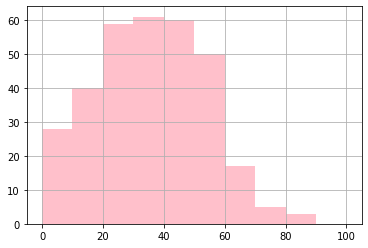

In [34]:
disney_df.apply(lambda x: x[1]*x[2],axis = 1).hist(color = 'pink', range = (0,100))

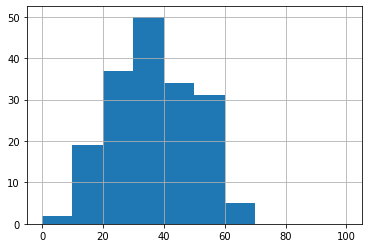

In [33]:
hayao_df.apply(lambda x: x[1]*x[2],axis = 1).hist(range = (0,100))

By comparing the histogram of the two datasets' size, we know that the images of these two different groups are roughly within the same range: 0-100. So the size of the images won't affect our prediction model we are building.

### 3.2 Hue

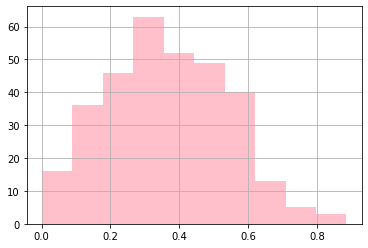

In [31]:
disney_df.mean_hue.hist(range = color = 'pink')

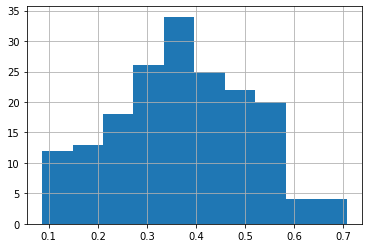

In [16]:
hayao_df.mean_hue.hist()

The values of mean hue of disney pictures seem more right skew than hayao's. There might be more red color in Disney's pictures.

### 3.3 Saturation

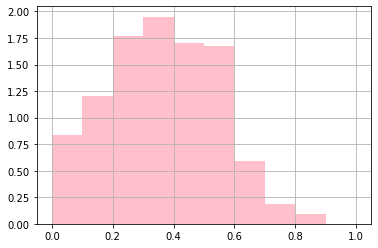

In [30]:
disney_df.mean_hue.hist(range = (0,1), density = True, color = 'pink')

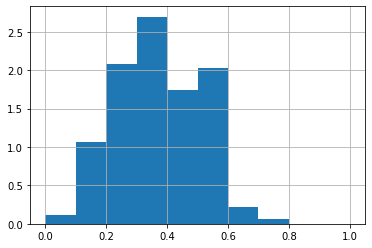

In [25]:
hayao_df.mean_hue.hist(range = (0,1),density = True)

The values of mean satuartion of disney pictures seem smaller than hayao's. Disney images might be more grey.

### 3.4 Value

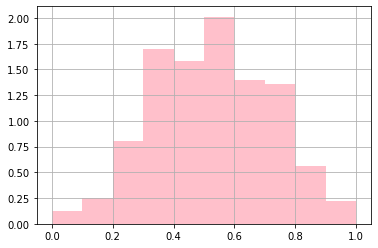

In [37]:
disney_df.mean_value.hist(range = (0,1), density = True, color = 'pink')

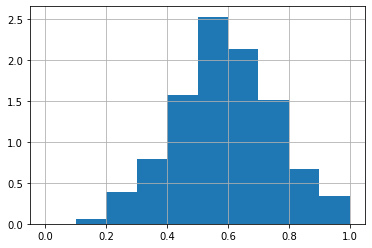

In [38]:
hayao_df.mean_value.hist(range = (0,1),density = True)

There's no obvious difference in mean values between these two datasets.

### 3.5 Entropy

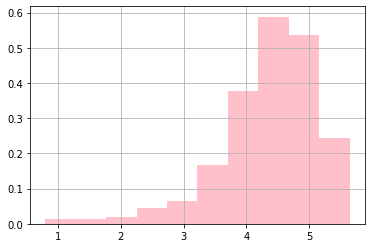

In [40]:
disney_df.mean_entropy.hist(range = (0,6),density = True, color = 'pink')

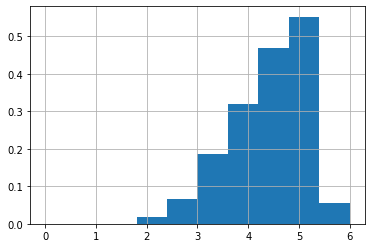

In [43]:
hayao_df.mean_entropy.hist(range = (0,6),density = True)

There might be some outliers in the disney datasets which makes it left skewed. But overall, hayao's pictures' entropy seems higher.

### 3.6 Edges

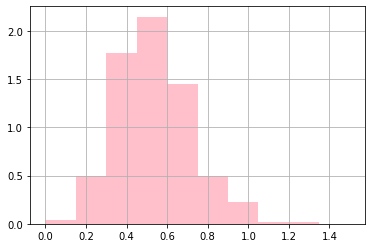

In [48]:
disney_df.edge_sum.hist(range = (0,1.5),density = True, color = 'pink')

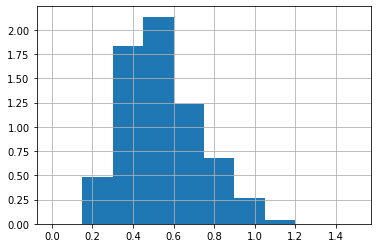

In [50]:
hayao_df.edge_sum.hist(range = (0,1.5),density = True)

These two distributions seem alike.